# Estimación con kernels densidad

**Kernel density estimation (KDE)** es una aproximación no paramétrica a la estimación de densidades. Puede interpretarse como un modelo generativo ya que define una distribución de probabilidad $p(\boldsymbol{x})$ que puede evaluarse en cualquier punto y, por tanto, puede muestrearse para generar nuevos datos.

## Kernels densidad

Un **kernel densidad** es una función $\mathcal{K}:\mathbb{R}\to\mathbb{R}^{\geq 0}$ simétrica que integra a uno:
$$\int\mathcal{K}(x)\,dx=1%
\qquad\text{y}\qquad%
\mathcal{K}(-x)=\mathcal{K}(x)$$
La simetría implica $\int x\mathcal{K}(x)\,dx=0$ y, en general:
$$\int x\mathcal{K}(x-x_n)\,dx=x_n$$
Algunos kernels populares son:
$$\begin{align*}
&\text{Gaussiano:}    &&\mathcal{K}(x)=(2\pi)^{-\frac{1}{2}}e^{-x^2/2}%
&&\text{diferenciable, pero no compacto}\\%
&\text{Tophat:}       &&\mathcal{K}(x)=\frac{1}{2}\mathbb{I}(\lvert{x}\rvert\leq 1)%
&&\text{compacto, pero no diferenciable}\\%
&\text{Epanechnikov:} &&\mathcal{K}(x)=\frac{3}{4}(1-x^2)\,\mathbb{I}(\lvert{x}\rvert\leq 1)%
&&\text{compacto y diferenciable salvo fronteras}%\\%
%&\text{Tri-cube:}     &&\mathcal{K}(x)=\frac{70}{81}(1-\lvert{x}\rvert^3)^3\,\mathbb{I}(\lvert{x}\rvert\leq 1)%
%&&\text{compacto y diferenciable}%
\end{align*}$$

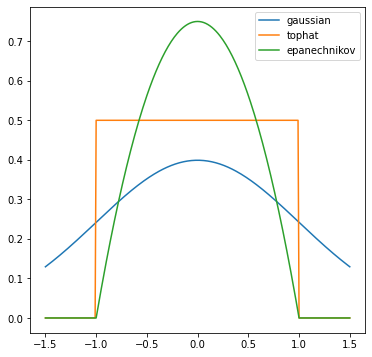

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
X = np.arange(-1.5, 1.501, 0.01)[:, np.newaxis]
plt.figure(figsize=(6, 6)); 
for K in ['gaussian', 'tophat', 'epanechnikov']:
    kde = KernelDensity(kernel=K, bandwidth=1).fit([[.0]])
    log_dens = kde.score_samples(X)
    plt.plot(X, np.exp(log_dens), label=K)
plt.legend();

Con el fin de controlar el ancho de un kernel, introducimos un parámetro **bandwidth** o **ancho de banda** h>0:
$$\mathcal{K}_h(x)=\frac{1}{h}\mathcal{K}\left(\frac{x}{h}\right)$$

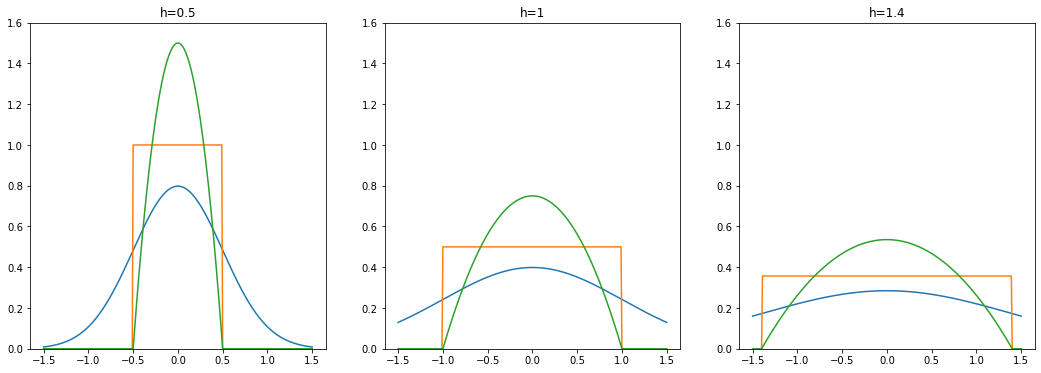

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
X = np.arange(-1.5, 1.501, 0.01)[:, np.newaxis]
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
for i, h in enumerate([.5, 1, 1.4]):
    axes[i].set_title(r'h={}'.format(h))
    axes[i].set_ylim(0, 1.6)
    for K in ['gaussian', 'tophat', 'epanechnikov']:
        log_dens = KernelDensity(kernel=K, bandwidth=h).fit([[.0]]).score_samples(X)
        axes[i].plot(X, np.exp(log_dens))

El kernel **radial basis function (RBF)** generaliza los kernels 1d a vectores:
$$\mathcal{K}_h(\boldsymbol{x})\propto\mathcal{K}_h(\lVert\boldsymbol{x}\rVert)$$
En el caso del kernel Gaussiano, esta generalización es:
$$\begin{align*}
\mathcal{K}_h(\boldsymbol{x})%
&=\prod_{d=1}^D\mathcal{K}_h(x_d)\\%
&=\prod_{d=1}^D\dfrac{1}{h}\dfrac{1}{(2\pi)^{1/2}}\exp\left(-\dfrac{1}{2}\left[\dfrac{x_d}{h}\right]^2\right)\\%
&=\dfrac{1}{h^D(2\pi)^{D/2}}\prod_{d=1}^D\exp\left(-\dfrac{1}{2h^2}x_d^2\right)\\%
&=\dfrac{1}{h^D(2\pi)^{D/2}}\exp\left(-\dfrac{1}{2}\left[\dfrac{\lVert\boldsymbol{x}\rVert}{h}\right]^2\right)
\end{align*}$$
Nótese que $h$ juega el papel de desviación típica (en cada dimensión).

## Estimador de densidad ventana de Parzen

Una primera aproximación no paramétrica a la estimación de densidades podría ser una mixtura de coeficientes uniformes y componentes Gaussianas hiperesféricas de idéntico tamaño:
$$p(\boldsymbol{x}\mid\boldsymbol{\theta})%
=\frac{1}{K}\sum_{k=1}^K\mathcal{N}(\boldsymbol{x}\mid\boldsymbol{\mu},\sigma^2\mathbf{I})$$
Ahora bien, la estimación del número de componentes y sus medias puede resultar problemática. Alternativamente, podemos emplear tantas componentes como datos, de manera que cada dato sea la media de su propia componente:
$$p(\boldsymbol{x}\mid\mathcal{D})%
=\frac{1}{N}\sum_{n=1}^N\mathcal{N}(\boldsymbol{x}\mid\boldsymbol{x}_n,\sigma^2\mathbf{I})$$
El **Parzen window density estimator** o **kernel density estimator (KDE)** generaliza este modelo sustituyendo cada componente por un kernel densidad:
$$p(\boldsymbol{x}\mid\mathcal{D})%
=\frac{1}{N}\sum_{n=1}^N\mathcal{K}_h(\boldsymbol{x}-\boldsymbol{x}_n)$$
En comparación con una mixtura, KDE no requiere escoger el número de componentes ni estimar parámetros, salvo el ancho de banda; ahora bien, dado que requiere mantener todos los datos, su coste espacial y temporal es muy elevado.

**Ejemplo:** KDE en 1d con $6$ datos y kernel Gaussiano

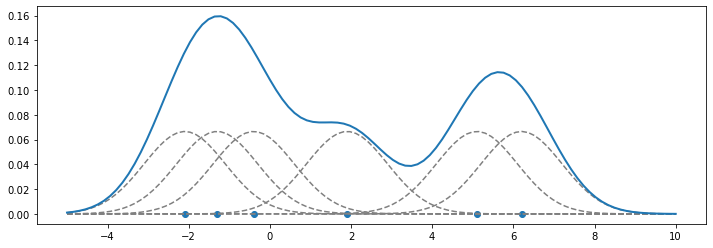

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
x_train = np.array([-2.1, -1.3, -0.4, 1.9, 5.1, 6.2])[:, np.newaxis]
N = x_train.shape[0]; h=1 # <<< bandwidth
x_test = np.linspace(-5, 10, 100)[:, np.newaxis]
plt.figure(figsize=(12, 4))
plt.scatter(x_train, np.zeros_like(x_train), marker="o")
for n in np.arange(N):
    x = x_train[n].reshape((1, 1))
    kde = KernelDensity(kernel='gaussian', bandwidth=h).fit(x)
    log_dens = kde.score_samples(x_test)
    plt.plot(x_test, np.exp(log_dens) / N, c="gray", linestyle="--")
kde = KernelDensity(kernel='gaussian', bandwidth=h).fit(x_train)
log_dens = kde.score_samples(x_test)
plt.plot(x_test, np.exp(log_dens), linewidth=2);

## Elección del parámetro ancho de banda

El ancho de banda "óptimo" para el kernel Gaussiano 1d es:
$$h=\sigma\left(\frac{4}{3N}\right)^{1/5}$$
Una aproximación robusta (frente a la presencia de outliers) para estimar $\sigma$ es:
$$\hat{\sigma}=1.4826\operatorname{MAD}$$
donde $\operatorname{MAD}$ es la **median absolute deviation:**
$$\operatorname{MAD}=\operatorname{median}(\lvert\boldsymbol{x}-\operatorname{median}(\boldsymbol{x})\rvert)$$
Si $D>1$, estimamos $h_d$ separadamente y tomamos:
$$h=\left(\prod_{d=1}^Dh_d\right)^{1/D}$$

## De clasificación KDE a KNN

El clasificador KNN puede verse como un clasificador generativo en el que las densidades condicionales de las clase se estiman mediante KDE. Más concretamente, la densidad condicional de la clase $c$ en un punto $\boldsymbol{x}$ se estima mediante un **KDE balloon** que hace crecer un volumen alrededor de $\boldsymbol{x}$ hasta encontrar $K$ datos, $V(\boldsymbol{x})$ (antes $h^D$):
$$p(\boldsymbol{x}\mid y=c,\mathcal{D})=\dfrac{\dfrac{N_c(\boldsymbol{x})}{N_c}}{V(\boldsymbol{x})}$$
donde $N_c(\boldsymbol{x})$ es el número de datos de la clase $c$ en $V(\boldsymbol{x})$ y $N_c$ es el total de datos de la clase $c$ (en $\mathcal{D}$). Si las proabilidades a priori de las clases se estiman como frecuencias relativas, la posterior de la clase $c$ coincide con la estimación (heurística) de KNN:
$$p(y=c\mid\boldsymbol{x},\mathcal{D})%
=\dfrac{\dfrac{N_c(\boldsymbol{x})}{N_cV(\boldsymbol{x})}\dfrac{N_c}{N}}{\sum_{c'}\dfrac{N_{c'}(\boldsymbol{x})}{N_{c'}V(\boldsymbol{x})}\dfrac{N_{c'}}{N}}%
=\dfrac{N_c(\boldsymbol{x})}{\sum_{c'}N_{c'}(\boldsymbol{x})}%
=\dfrac{N_c(\boldsymbol{x})}{K}%
=\dfrac{1}{K}\sum_{n\in N_K(\boldsymbol{x},\mathcal{D})}\mathbb{I}(y_n=c)$$

## Regresión kernel

Al igual que clasificadores generativos, KDE puede usarse para construir modelos de regresión generativos. En regresión, queremos calcular la esperanza condicional:
$$\mathbb{E}[y\mid\boldsymbol{x},\mathcal{D}]%
=\int y\,p(y\mid\boldsymbol{x},\mathcal{D})\,dy%
=\dfrac{\int y\,p(\boldsymbol{x},y\mid\mathcal{D})\,dy}{\int p(\boldsymbol{x},y\mid\mathcal{D})\,dy}$$
Si usamos una Gaussiana multivariada para $p(\boldsymbol{x},y\mid\mathcal{D})$, obtenemos un modelo equivalente a regresión lineal que resulta bastante limitado; KDE facilita una aproximación más precisa. En particular, el **modelo Nadaraya-Watson** emplea KDE para aproximar la densidad conjunta como:
$$p(\boldsymbol{x},y\mid\mathcal{D})%
\approx\frac{1}{N}\sum_{n=1}^N\mathcal{K}_h(\boldsymbol{x}-\boldsymbol{x}_n)\,\mathcal{K}_h(y-y_n)$$
Así, la esperanza condicional de la salida puede estimarse como una media ponderada de las salidas de los datos:
$$\begin{align*}\mathbb{E}[y\mid\boldsymbol{x},\mathcal{D}]%
&=\dfrac{\dfrac{1}{N}\sum_{n=1}^N\mathcal{K}_h(\boldsymbol{x}-\boldsymbol{x}_n)\overbrace{\int y\,\mathcal{K}_h(y-y_n)\,dy}^{y_n}}{\dfrac{1}{N}\sum_{n=1}^N\mathcal{K}_h(\boldsymbol{x}-\boldsymbol{x}_n)\underbrace{\int \mathcal{K}_h(y-y_n)\,dy}_{1}}\\%
&=\dfrac{\sum_{n=1}^N\mathcal{K}_h(\boldsymbol{x}-\boldsymbol{x}_n)\,y_n}{\sum_{n=1}^N\mathcal{K}_h(\boldsymbol{x}-\boldsymbol{x}_n)}\\%
&=\sum_{n=1}^N y_n\,w_n(\boldsymbol{x})%
\qquad\text{con}\qquad%
w_n(\boldsymbol{x})=\dfrac{\mathcal{K}_h(\boldsymbol{x}-\boldsymbol{x}_n)}{\sum_{n'=1}^N\mathcal{K}_h(\boldsymbol{x}-\boldsymbol{x}_{n'})}
\end{align*}$$

**Ejemplo:** regresión kernel en 1d con un kernel Gaussiano

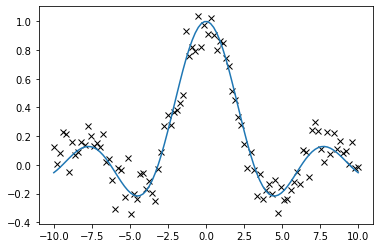

In [4]:
import numpy as np
import matplotlib.pyplot as plt
N_train = 100; noise = 0.1; N_test = 100; np.random.seed(0)
x_train = 10 * (np.linspace(-1, 1, N_train).reshape(-1, 1))
y_train = np.divide(np.sin(np.abs(x_train)), np.abs(x_train))
y_train += noise * np.random.randn(N_train, 1)
x_test = 10 * (np.linspace(-1, 1, N_test).reshape(-1, 1))
y_test = np.divide(np.sin(np.abs(x_test)), np.abs(x_test))
plt.plot(x_train, y_train, 'kx'); plt.plot(x_test, y_test);

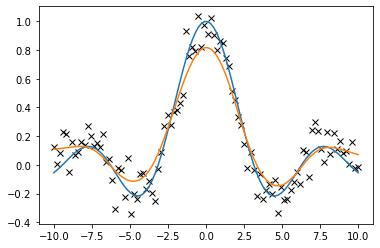

In [5]:
from sklearn.neighbors import KernelDensity
y_pred = np.zeros_like(y_test); w = np.zeros_like(x_train);
kde = KernelDensity(kernel='gaussian', bandwidth=1).fit([[.0]])
for i in np.arange(N_test):
    x = x_test[i].reshape(1, 1)
    w = np.exp(kde.score_samples(x - x_train))
    w = w / w.sum()
    y_pred[i] = np.dot(y_train.T, w)
plt.plot(x_train, y_train, 'kx'); plt.plot(x_test, y_test);
plt.plot(x_test, y_pred);

### Nadaraya-Watson Gaussiano con softmax

Dada una entrada $\boldsymbol{x}$, Nadaraya-Watson regresa una media ponderada de las salidas de los datos. Si se emplea un kernel Gaussiano, es fácil comprobar que los pesos son probabilidades obtenidas mediante normalización softmax de logits que miden la similitud (neg-distancia) entre $\boldsymbol{x}$ y cada dato:
$$\begin{align*}
w_n(\boldsymbol{x})%
&=\dfrac{\mathcal{K}_h(\boldsymbol{x}-\boldsymbol{x}_n)}{\sum_{n'=1}^N\mathcal{K}_h(\boldsymbol{x}-\boldsymbol{x}_{n'})}\\%
&=\dfrac{\dfrac{1}{h^D(2\pi)^{D/2}}\exp\left[-\dfrac{1}{2h^2}\lVert\boldsymbol{x}-\boldsymbol{x}_n\rVert^2\right]}{\sum\limits_{n'=1}^N\dfrac{1}{h^D(2\pi)^{D/2}}\exp\left[-\dfrac{1}{2h^2}\lVert\boldsymbol{x}-\boldsymbol{x}_{n'}\rVert^2\right]}\\%
&=S\left(\left\{-\dfrac{1}{2h^2}\lVert\boldsymbol{x}-\boldsymbol{x}_{n'}\rVert^2\right\}_{n'=1}^N\right)_n%
\end{align*}$$
Esta interpretación de Nadaraya-Watson con kernel Gaussiano se suele emplear en aprendizaje profundo como ejemplo ilustrativo de **mecanismo de atención (no paramétrico).** Las entradas de los datos constituyen un **diccionario** de **claves**, sus salidas los **valores** asociados a las claves, y la entrada $\boldsymbol{x}$ una **consulta (query)**. Los pesos que Nadaraya-Watson otorga a los datos tras la consulta se denominan **pesos de atención**, mientras que sus logits correspondientes reciben el nombre de **scores de atención.** En estos términos, puede decirse que el mecanismo de atención es 
un modelo de regresión condicional que presta mayor atención a las claves que se parecen a la consulta. Los populares **transformers** se basan en el mecanismo de atención principalmente.

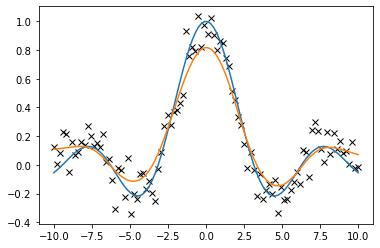

In [6]:
h = 1.0; negsqL2 = lambda x: -0.5 * np.inner(x, x) / h
y_pred = np.zeros_like(y_test); w = np.zeros_like(x_train);
for i in np.arange(N_test):
    z = x_test[i] - x_train
    logits = np.apply_along_axis(negsqL2, 1, z)
    logits -= np.max(logits); w = np.exp(logits); w /= w.sum()
    y_pred[i] = np.dot(y_train.T, w)
plt.plot(x_train, y_train, 'kx'); plt.plot(x_test, y_test);
plt.plot(x_test, y_pred);